# Telecommunications Customer Churn EDA

This notebook is a more raw version of the churn_eda.py file where I have more comments here describing what I'm doing as well as visualizations since Jupyter notebook is easier to do visualizations. 

## 1. Data Preprocessing

### 1.1 Data Collection

#### 1.1.1 Import Packages and Load Dataset

In [178]:

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt 

In [179]:
# load data
telco_orig_data = pd.read_csv("/Users/tonyzhang/Desktop/customerchurn/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

### 1.2 Data Cleaning

#### 1.2.1 High Level Overview of Data

In [180]:
telco_orig_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

there are a lot of object data types, so we need to perform feature engineering to convert them to numerical data types. 

In [181]:
# let's look at the descriptive statistics of the numerical data types
telco_orig_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


- SeniorCitizen is actually a categorical variable so we can disregard. 
- 75% of customers have tenure less than 55 months. 
- The average monthly charges for customers are $64.76 and 25% of customers pay more than $89.85. 

In [182]:
churn=(telco_orig_data['Churn'].value_counts(normalize=True))*100


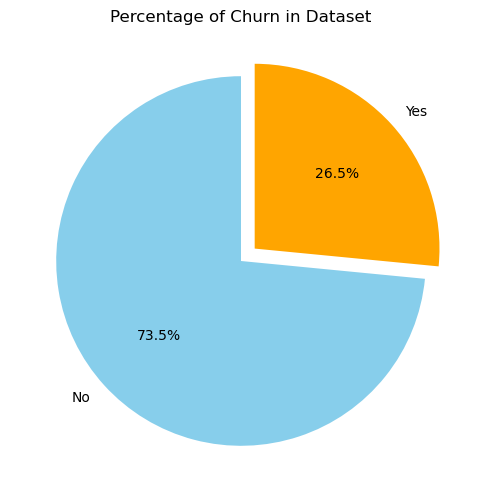

In [183]:
# visulize using pie chart 
plt.figure(figsize=(8,6))
plt.pie(churn, labels=churn.index, autopct='%1.1f%%', startangle=90, colors = ['skyblue', 'orange'], explode = (0, 0.1))
plt.title('Percentage of Churn in Dataset'); plt.show()

Churn data is highly imbalanced (No=73.5% Yes=26.5%), and we're building a classification model so we need some way to balance the data, either oversampling or undersampling. 

#### 1.2.2 Handling Missing Data Values

In [184]:
# create copy of data for manipulation
telco_data = telco_orig_data.copy()

Text(0, 0.5, 'Percentage')

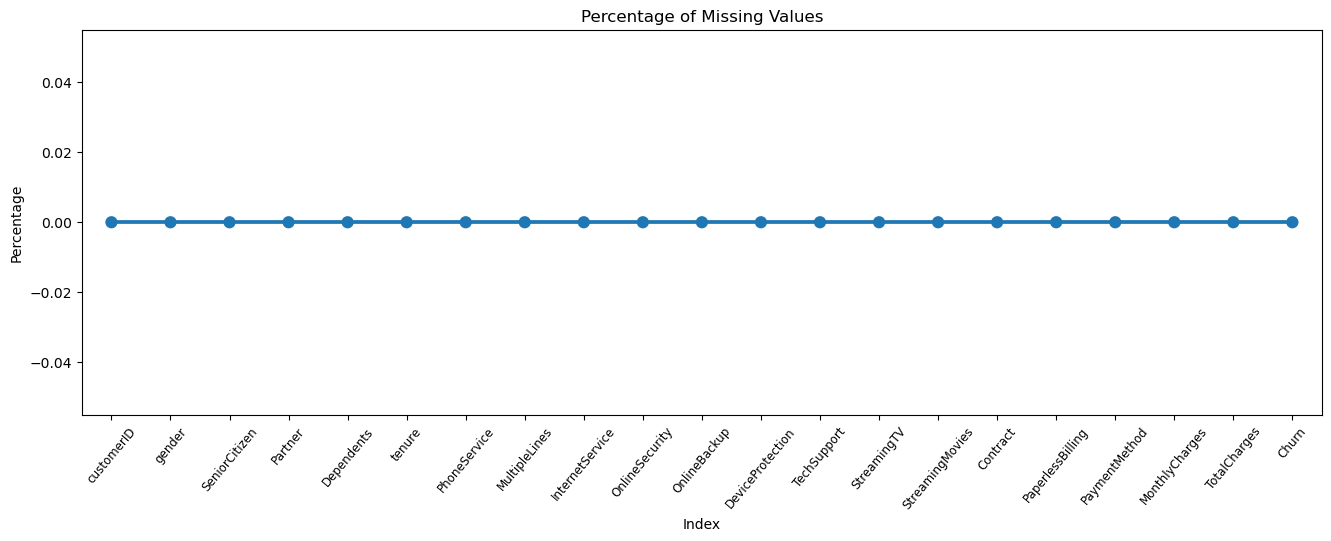

In [185]:
missing = pd.DataFrame((telco_data.isnull().sum() * 100) / telco_data.shape[0]).reset_index()
missing.columns = ['Index', 'Percentage Missing']
plt.figure(figsize=(16, 5))
ax = sns.pointplot(x='Index', y='Percentage Missing', data=missing)
plt.xticks(rotation=50, fontsize=8.5)
plt.title("Percentage of Missing Values")
plt.xlabel("Index")
plt.ylabel("Percentage")

As we can see in the point plot, there are no missing values in any of the columns in the dataset so we don't need to do any missing value handling. 

#### 1.2.3 Convert TotalChanges to Numerical

In [186]:
telco_data.TotalCharges.dtype

dtype('O')

The TotalCharges column is an Object column, event though it contains numbers. They're represented as strings as numbers instead of actual numerical values. We have to convert them to numerical values. 

In [187]:
telco_data.TotalCharges = pd.to_numeric(telco_data.TotalCharges, errors='coerce') # coerce will introduce NA values for non-numeric data in the columns
telco_data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Now that we have converted TotalCharges to an int data type, handling errors with the 'coerce' method, we now have 11 null values. Let's explore further.

In [188]:
totalcharge_null = telco_data[telco_data['TotalCharges'].isnull()].shape[0]
(totalcharge_null / telco_data.shape[0]) * 100

0.1561834445548772

Since the percentage of 'TotalCharges' null values are only 0.15% of all 'TotalCharges' values, it is safe to ignore them from further processing. 

In [189]:
telco_data.dropna(how='any', inplace=True)

#### 1.2.4 Split dataset into bins based on different tenure lengths. 
Tenure lengths is one of the most important metrics when it comes to determining customer churn potential, as customers with shorter tenure lengths tend to have a higher rate of churning compared to customers with higher tenure lengths. By binning our dataset based on different tenure lengths, we  make analyzing each type of tenure length customers easier and to give us an easier time devising strategies for each tenure length types of customers

In [190]:
telco_data['tenure'].max() # 72 months, so our max bin range stops at 6 years

# group tenure in bins of 12 months 
labels = ['{0} - {1}'.format(i, i + 11) for i in range(1, 72, 12)]
telco_data['tenure_group'] = pd.cut(telco_data.tenure, range(1, 80, 12), right=False, labels=labels)
telco_data['tenure_group'].value_counts(normalize=True)*100

1 - 12     30.930034
61 - 72    20.008532
13 - 24    14.562002
25 - 36    11.831627
49 - 60    11.831627
37 - 48    10.836177
Name: tenure_group, dtype: float64

In [191]:
telco_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,13 - 24
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,61 - 72
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,1 - 12
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,1 - 12


from the binned dataset, we can see that 30.9% of customers are new customers and 20% of customers are long time customers. 

The **pd.cut** function in pandas operates by examining each value in the 'tenure' column and determining which bin (range) that value falls into. It then assigns the corresponding bin label to that value

#### 1.2.5 Drop 'customerID' and 'tenure' column

We're dropping 'customerID' column because the values in this column doesn't serve any significant purpose for when we train the model. The model cannot predict whether a customer will churn based on a random customerID, the values are nothing but random letters and numbers used to identified a customer. 

In addition, since we split our dataset into bins based on tenure ranges, there is no longer a need for the 'tenure' column as that would overcomplicate the training process for the model as the tenure column values are already taken in account by having the dataset values in its respective bins sorted by tenure length. 

In [192]:
telco_data.drop(columns=['customerID', 'tenure'], axis=1, inplace=True)


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'tenure_group'],
      dtype='object')